In [1]:
from Chemometrics.import_common import *
from redis import Redis
import tempfile
import json
from gen_data import gen_TrainData, gen_TrainParams, gen_predict_params
from sklearn.datasets import load_wine, load_diabetes, \
load_breast_cancer, load_iris, load_linnerud, load_boston
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.style.use('ggplot')

# 生成数据

In [2]:
rdb = Redis(host="192.168.1.135", port=6379, db=1, password='fredis-00')

In [3]:
a = pd.read_json(rdb.get('VOCs-CAS'), orient='index')

PLSR模型交叉验证最佳潜变量数目为 10


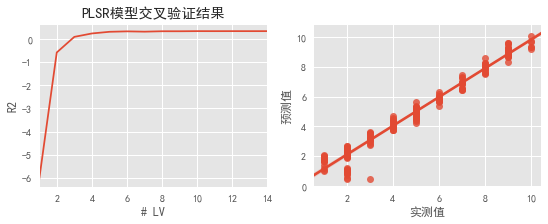

In [4]:
dataset = load_wine()
np.random.seed(1)

# 加噪音
X = np.hstack([dataset.data, np.std(dataset.data)*np.random.randn(dataset.data.shape[0], 5)])

# 生成y
plsr = PLSRegression(n_components=4)
y = abs(np.round(plsr.fit(X, dataset.target).predict(X).flatten()*4))+1

# X, y PLSR交叉验证结果
param_grid = {'n_components': range(1,15,1)}
np.random.seed(1)
plsr = PLSRegression()
grid = GridSearchCV(plsr,param_grid, cv=3)
grid.fit(X, y)
print('PLSR模型交叉验证最佳潜变量数目为 {}'.format(grid.best_estimator_.n_components))
plt.figure(figsize=(9,3))
plt.subplot(1, 2, 1)
pd.DataFrame(dict(grid.cv_results_)).set_index('param_n_components').mean_test_score.plot()
plt.title('PLSR模型交叉验证结果')
plt.xlabel('# LV')
plt.ylabel('R2')
plt.subplot(1, 2, 2)
sns.regplot(y, grid.predict(X).flatten())
plt.xlabel('实测值')
plt.ylabel('预测值')

In [5]:
#中汽ODT数据
# ODT1 = pd.read_excel('./ODT数据2.xlsx')
# ODT1.set_index("CAS", inplace=True)
# target = ODT1.pop("ODT(p.ol vol)")
# X = ODT1.loc[(ODT1>0).any(axis=1)]
# y = target.loc[X.index]
# X.shape, y.shape

In [6]:
plsr = PLSRegression(n_components=10)
plsr.fit(X, y)
plsr.score(X, y)

0.9648543263152098

---
# 数据分析EDA

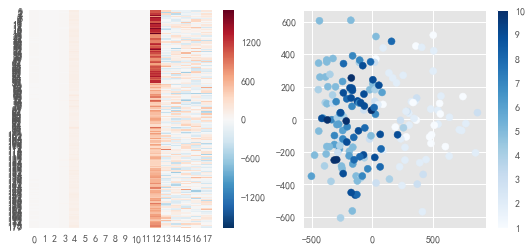

In [7]:
plt.figure(figsize=(9, 4))

# X热图
plt.subplot(1, 2, 1)
sns.heatmap(X)

# X主成分分析
plt.subplot(1, 2, 2)
pca = PCA(n_components=2)
score = pca.fit_transform(X)
plt.scatter(score[:,0], score[:,1], c=y, cmap=plt.cm.Blues)
plt.colorbar()

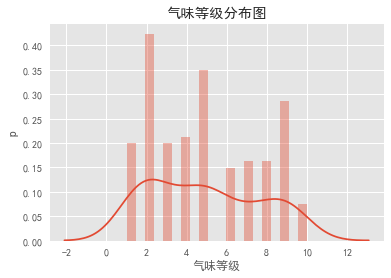

In [8]:
sns.distplot(y, bins=20)
plt.xlabel('气味等级')
plt.title('气味等级分布图')
plt.ylabel('p')

In [9]:
# todo correlation

----
# 没有test

PLSR模型交叉验证最佳潜变量数目为 10


0.9648543263152098

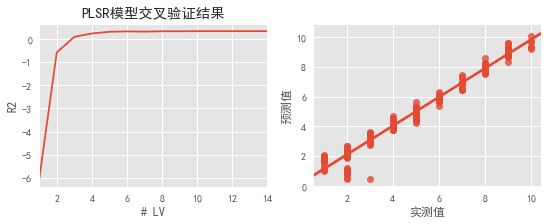

In [10]:
# X, y PLSR交叉验证结果
param_grid = {'n_components': range(1,15,1)}
np.random.seed(1)
plsr = PLSRegression()
grid = GridSearchCV(plsr,param_grid, cv=3)
grid.fit(X, y)
print('PLSR模型交叉验证最佳潜变量数目为 {}'.format(grid.best_estimator_.n_components))
plt.figure(figsize=(9,3))
plt.subplot(1, 2, 1)
pd.DataFrame(dict(grid.cv_results_)).set_index('param_n_components').mean_test_score.plot()
plt.title('PLSR模型交叉验证结果')
plt.xlabel('# LV')
plt.ylabel('R2')
plt.subplot(1, 2, 2)
sns.regplot(y, grid.predict(X).flatten())
plt.xlabel('实测值')
plt.ylabel('预测值')
grid.score(X, y)

---
# Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(\
                        X, y, test_size=0.33, random_state=1)

In [12]:
param_grid = {'n_components': range(2,15,1)}
grid = GridSearchCV(plsr, param_grid, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': range(2, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

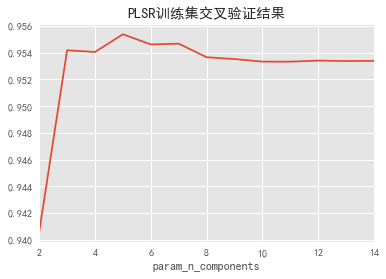

In [13]:
pd.DataFrame(dict(grid.cv_results_)).set_index('param_n_components').mean_test_score.plot()
plt.title('PLSR训练集交叉验证结果')

0.9713847455872336

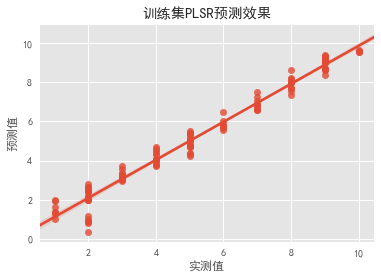

In [14]:
best_model = grid.best_estimator_
sns.regplot(y_train, best_model.predict(X_train).flatten())
plt.title('训练集PLSR预测效果')
plt.xlabel('实测值')
plt.ylabel('预测值')
best_model.score(X_train, y_train)

0.941199757742963

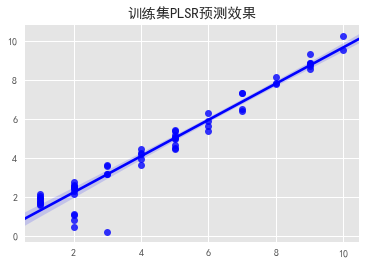

In [15]:
sns.regplot(y_test, best_model.predict(X_test).flatten(),color='b')
best_model.score(X_test, y_test)
plt.title('训练集PLSR预测效果')
best_model.score(X_test, y_test)

In [16]:
# kNN todo

# 生成数据

In [17]:
#生成dfs
a_ = a.dropna()
CAS = a_.index.values
a_.index.name='CAS'
a_.reset_index(inplace=True)
def func(s,a):
    s_ = s.reset_index()
    s_.columns=['CAS','Concentration']
    df = pd.merge(s_,a_,how='inner',on='CAS')
    return df

In [18]:
to_json = True
prefix = 'wine'
if to_json:
    X_ = pd.DataFrame(X, columns=CAS[:X.shape[1]]).T
    X_.index.name='CAS'
    dfs = [func(X_.loc[:,i],a_) for i in range(X_.shape[1])]
    dfs = {'sample'+str(i):dfs[i] for i in range(len(dfs))}
    y = pd.Series(y, index=('sample'+str(i) for i in range(len(dfs))),dtype=np.float64)
    # rps = gen_representative(dfs, num_rps=5, seed=1)
    # CommonPattern = common_pattern(rps)
    # # dfs = fmt(CommonPattern, dfs) #对齐

    TrainData = gen_TrainData(y, dfs)
    TrainParams = gen_TrainParams(TrainData)
    PredictParams = gen_predict_params(TrainData)

    # 生成训练数据
    with tempfile.NamedTemporaryFile('w', prefix=prefix+'_train_', suffix='.json',encoding='utf-8', delete=False) as f:
        json.dump(TrainParams, f)

    # 生成预测数据
    with tempfile.NamedTemporaryFile('w', prefix=prefix+'_test_', suffix='.json', encoding='utf-8', delete=False) as f:
        json.dump(PredictParams, f)

In [21]:
_xls = True
if _xls:
    X_.T.to_excel('./中汽测试数据.xls')
    y.reset_index(drop=True).to_excel('./中汽测试数据target.xls')
    pd.concat([X_.T, y.reset_index(drop=True)], axis=1).to_excel('中汽测试数据Xy.xls')

In [20]:
# Chempattern PLSR 验证